# Final Project NLP - SMALL VERSION

- Author: Erik Buunk
- Date: 2020-07-26
- Version: 0.5

Changes:
- 0.4: excl. Pop
- 0.4a: Colab version
- 0.5: include metal

The purpose of this note book to get acquinted with the data to know which operations were needed for the final dataset. 
Also a basline performance was done, from which further development of the model was determined.


## Data files:
- metal_songs.csv
- artist-data.csv
- lyrics-data.csv

## Settings:
- set `COLAB = True` if you run this on Colab. Data can be placed in the root directory

In [3]:
# setup
import sys
import subprocess
import pkg_resources
from collections import Counter
import re
from numpy import log, mean, matmul


# required = {'spacy', 'scikit-learn', 'numpy', 
#             'pandas', 'torch', 'matplotlib',
#             'transformers', 'allennlp==0.9.0'}
# installed = {pkg.key for pkg in pkg_resources.working_set}
# missing = required - installed

# if missing:
#     python = sys.executable
#     subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)
import spacy
import numpy as np
import pandas as pd

# SciKit Learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.svm import SVC


# Spacy
from spacy.lang.en import English
en = English()

# !python -m spacy download en_core_web_md # includes GloVe Vectors
# !python -m spacy download en_core_web_sm
# !python -m spacy download en

# import en_core_web_sm
# import en_core_web_md


# PyTorch
import torch
# import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# File managment
import os
from os import listdir
from pathlib import Path
import pickle
import gzip


In [4]:
LOAD_DATA = False # read save data or regenerate data
SAVE_DATA = False # overwrite generated data? 

COLAB = True

In [5]:
if COLAB:
  # Google Colab
  path = "./"
  device = torch.device("cuda:0") # use GPU, change 
else:
  # Laptop
  path = "./data/"
  device = torch.device("cpu")
#   !pip install ipywidgets
#   !jupyter nbextension enable --py widgetsnbextension


# Functions

In [6]:
def show_data():
  for dirname, _, filenames in os.walk(path):
      for filename in filenames:
          print(os.path.join(dirname, filename))

# show_data()

In [7]:
def save_pickle(filename, data):
    with open(f"{path}{filename}", "wb") as fp: 
      pickle.dump(data, fp)

def load_pickle(filename):
    with open(f"{path}{filename}", 'rb') as f:
      return pickle.load(f)
    
def save_file(filename, train_tokens, test_tokens, val_tokens):
  data = {"train_tokens": train_tokens, "test_tokens" : test_tokens, "val_tokens": val_tokens}

  with open(f"{path}{filename}", "wb") as fp: 
    pickle.dump(data, fp)
    
def load_file(filename):
  with open(f"{path}{filename}", 'rb') as f:
      all_text = pickle.load(f)
      return (all_text["train_tokens"], all_text["test_tokens"], all_text["val_tokens"])


In [8]:
def split_train_val_test (X, y, pct_train = 0.7, pct_val = 0.3):
  np.random.seed(0)
  train_bool = np.random.random(len(X)) <= pct_train
  x_train = X[train_bool]
  y_train = y[train_bool]

  x_test = X[~train_bool]
  y_test = y[~train_bool]

  # split the training 30% for validation
  val_bool = np.random.random(size=len(x_train)) <= pct_val
  x_val = x_train[val_bool]
  y_val = y_train[val_bool]

  # exclude validation from training
  x_train = x_train[~val_bool]
  y_train = y_train[~val_bool]
  
  #check lengths
  print("Training: ", len(x_train), len(y_train))
  print("Validation: ", len(x_val), len(y_val))
  print("Test: ", len(x_test), len(y_test))
  
  return x_train, y_train, x_val, y_val, x_test, y_test

# Load Data

In [9]:
# if LOAD_DATA:
#   df_total = pd.read_csv(f'{path}df_total.csv')
#   df_small = pd.read_pickle(f'{path}df_small.pkl.gz')
#   (x_test, x_val, x_test, y_train, y_val, y_test) = load_pickle('data_split_sm.pkl') # based on the sampled small data set

#   lyrics_bert_vectors_train = pd.read_pickle(f'{path}lyrics_bert_vectors_train.pkl.gz')
#   lyrics_bert_vectors_val = pd.read_pickle(f'{path}lyrics_bert_vectors_val.pkl.gz')
#   lyrics_bert_vectors_test = pd.read_pickle(f'{path}lyrics_bert_vectors_test.pkl.gz')

  
# # TODO: part of the data preparation can be skipped here of the data is pre-loaded

In [10]:
# Read data
df_artist =  pd.read_csv(f'{path}artists-data.csv')

In [11]:
df_lyrics = pd.read_csv(f'{path}lyrics-data.csv')

In [12]:
df_metal = pd.read_csv(f'{path}metal_songs.csv')

# Data exploration and data preparation
- [x] Check distribution of the data. (genres, artists, lyrics, languages)
- [x] Data analysis: is the data usable, what needs to be cleaned. Visual inspection.
- [ ] Top words, word counts leading to a basic tokenizer.
- [x] Cosine similarity between document genres. 
- [ ] Create a base pipeline, word counts/TFIDF
- [ ] Visualizations


In [13]:
print(df_artist.columns)
print(df_lyrics.columns)
print(df_metal.columns)

Index(['Artist', 'Songs', 'Popularity', 'Link', 'Genre', 'Genres'], dtype='object')
Index(['ALink', 'SName', 'SLink', 'Lyric', 'Idiom'], dtype='object')
Index(['Genre', 'Artist', 'Song', 'Lyric'], dtype='object')


#### Lyrics

In [14]:
df_lyrics.shape

(50000, 5)

In [15]:
df_lyrics["Idiom"].value_counts().head(n=10)

ENGLISH        27229
PORTUGUESE     20507
SPANISH         1100
ITALIAN          145
FRENCH           121
GERMAN            72
KINYARWANDA       16
ESTONIAN           5
SWEDISH            5
CROATIAN           4
Name: Idiom, dtype: int64

For this project we will use English only.

In [16]:
df_lyrics_en = df_lyrics.query("Idiom == 'ENGLISH'")
df_lyrics_en = df_lyrics_en.drop(["SLink", "Idiom"], axis=1)
df_lyrics_en.shape

(27229, 3)

In [17]:
df_lyrics_en

,ALink,SName,Lyric
0,/ace-hood/,We On,"Okay. Uh, okay I walked in the party and it's ..."
2,/foxy-brown/,The Chase,"Uhhhh yeahhhh uh, The Firm. Lust... hate... en..."
3,/nick-jonas/,Avalanche (Feat. Demi Lovato),Words like a loaded gun. Shot out from a fire ...
6,/sonic-youth/,Wildflower Soul,sing yr children. yr children song. sing yr lo...
7,/tarja-turunen/,I Walk Alone,Put all your angels on the edge. Keep all the ...
...,...,...,...
49992,/fleetwood-mac/,Welcome To The Room... Sara,Written by Stevie Nicks.. . It's not home. And...
49993,/b-o-b/,Grand Hustle Kings (Feat. Young Dro & T.i.),I'll be questioning ain't gonna be … hold up. ...
49994,/avenged-sevenfold/,An Epic of Time Wasted,So much time I've wasted.. I can truly say I n...
49996,/shanell/,Cha-Ching (Feat. Millionaires),[Hook]. Cha-ching. Cha-ching. Let me here you ...


#### Artist

In [18]:
# origianl query:
df_artist_sm = df_artist.query("Genre == 'Rock' | Genre == 'Pop' | Genre == 'Hip Hop'")

# 2 category:
# df_artist_sm = df_artist.query("Genre == 'Rock' | Genre == 'Hip Hop'")

total = df_artist_sm.shape[0]
100*df_artist_sm["Genre"].value_counts()/total

Rock       37.417840
Pop        37.370892
Hip Hop    25.211268
Name: Genre, dtype: float64

In [19]:
# original
genres = ["Rock", "Pop", "Hip Hop"]

# 2 category
# genres = ["Rock", "Hip Hop", "Metal"]
genres.sort()

total_songs = df_artist_sm["Songs"].sum()
print(f"Total Songs: {total_songs}")
for i in genres:
    percentage = round(100*df_artist_sm[df_artist_sm.Genre == i]["Songs"].sum()/total_songs, 2 )
    print(f"{i} {percentage}%")

Total Songs: 127523
Hip Hop 17.03%
Pop 34.15%
Rock 48.82%


In [20]:
df_artist_sm_red = df_artist_sm.drop(["Genres", "Popularity", "Songs"], axis = 1)

In [21]:
df_artist_sm_red

,Artist,Link,Genre
0,10000 Maniacs,/10000-maniacs/,Rock
1,12 Stones,/12-stones/,Rock
2,311,/311/,Rock
3,4 Non Blondes,/4-non-blondes/,Rock
4,A Cruz Está Vazia,/a-cruz-esta-vazia/,Rock
...,...,...,...
3227,Tati Quebra Barraco,/tati-quebra-barraco/,Hip Hop
3228,Valesca Popozuda,/valesca-popozuda/,Pop
3229,Vine Rodry,/vine-rodry/,Pop
3234,Leandro Sapucahy,/leandro-sapucahy/,Pop


In [22]:
# Remove duplicate Link values

# pd.DataFrame(df_artist_sm["Link"].value_counts())
(df_artist_sm_red["Link"].value_counts() > 1).sum()

144

In [23]:
# drop duplicates
df_artist_dedup = df_artist_sm_red.drop(df_artist_sm_red[df_artist_sm_red.Link.duplicated()].index)

In [24]:
# Some artist have multiple genrese. These are removed.

(df_artist_dedup["Link"].value_counts() > 1).sum()
df_artist_dedup[df_artist_dedup["Artist"] =='10000 Maniacs']

,Artist,Link,Genre
0,10000 Maniacs,/10000-maniacs/,Rock


#### Metal lyrics

In [25]:
df_metal = pd.read_csv(f'{path}metal_songs.csv')
df_metal.head()

,Genre,Artist,Song,Lyric
0,Metal,Melvins,Hdyf,\n
1,Metal,Zakk Wylde,I Thank You Child,All for you\nEverlasting love forever skies of...
2,Metal,Zemial,In The Arms Of Hades,Black winged demons haunt the dungeons where t...
3,Metal,Znowhite,War Machine,Youâre no stranger\nYouâve been this way b...
4,Metal,Melvins,Dry Drunk,\n


In [26]:
# drop instrumental songs
df_metal = df_metal[df_metal["Lyric"]!= ' Instrumental   ']
df_metal

,Genre,Artist,Song,Lyric
0,Metal,Melvins,Hdyf,\n
1,Metal,Zakk Wylde,I Thank You Child,All for you\nEverlasting love forever skies of...
2,Metal,Zemial,In The Arms Of Hades,Black winged demons haunt the dungeons where t...
3,Metal,Znowhite,War Machine,Youâre no stranger\nYouâve been this way b...
4,Metal,Melvins,Dry Drunk,\n
...,...,...,...,...
1870,Metal,Melvins,Prig,All the hand and other land\nAnd all I've done...
1871,Metal,Damageplan,Breathing New Life,CAN YOU FEEL IT BUILDING\nDEVASTATION IS ON TH...
1872,Metal,Zimmer S Hole,Anonymous Esophagus,Anonymous Esophagus\nYou love to scream and sh...
1873,Metal,Melvins,You Ve Never Been Right,"The rabies, and what we think is right\nWe're ..."


In [27]:
df_metal = df_metal[~df_metal["Lyric"].isnull()]

In [28]:
l = df_metal["Lyric"].apply(lambda x: x.strip())
l

0                                                        
1       All for you\nEverlasting love forever skies of...
2       Black winged demons haunt the dungeons where t...
3       Youâre no stranger\nYouâve been this way b...
4                                                        
                              ...                        
1870    All the hand and other land\nAnd all I've done...
1871    CAN YOU FEEL IT BUILDING\nDEVASTATION IS ON TH...
1872    Anonymous Esophagus\nYou love to scream and sh...
1873    The rabies, and what we think is right\nWe're ...
1874    If the end be a comin'\nI soon be a bummin'\nA...
Name: Lyric, Length: 1875, dtype: object

In [29]:
df_metal = df_metal[l!='']

In [30]:
df_metal2 = pd.DataFrame({"SName" : df_metal["Song"],	
                          "Lyric": df_metal["Lyric"],  	
                          "Artist" : df_metal["Artist"],  	
                          "Genre": df_metal["Genre"]})
                         
                       
                         
df_metal2                         

,SName,Lyric,Artist,Genre
1,I Thank You Child,All for you\nEverlasting love forever skies of...,Zakk Wylde,Metal
2,In The Arms Of Hades,Black winged demons haunt the dungeons where t...,Zemial,Metal
3,War Machine,Youâre no stranger\nYouâve been this way b...,Znowhite,Metal
6,The Frontiersman,I dream of a new life\nAn oath that's to repay...,Damnation Angels,Metal
7,V,I don't want to be blind\nI don't want to be t...,Zeromancer,Metal
...,...,...,...,...
1870,Prig,All the hand and other land\nAnd all I've done...,Melvins,Metal
1871,Breathing New Life,CAN YOU FEEL IT BUILDING\nDEVASTATION IS ON TH...,Damageplan,Metal
1872,Anonymous Esophagus,Anonymous Esophagus\nYou love to scream and sh...,Zimmer S Hole,Metal
1873,You Ve Never Been Right,"The rabies, and what we think is right\nWe're ...",Melvins,Metal


#### Join the data

In [31]:
# join the two data frames
df_lyrics_prejoin = df_lyrics_en.set_index('ALink')
df_artist_prejoin = df_artist_dedup.set_index('Link')
df_total = df_lyrics_prejoin.join(df_artist_prejoin)

In [32]:
# check that the join is correct
df_total.shape

(27229, 4)

In [33]:
df_total

,SName,Lyric,Artist,Genre
/10000-maniacs/,Sally Ann,A woman of beauty. A woman of pain. In france ...,10000 Maniacs,Rock
/10000-maniacs/,Hidden In My Heart,"Music by 10,000 Maniacs - Lyrics by Mary Ramse...",10000 Maniacs,Rock
/10000-maniacs/,Poison In The Well,[ music: Dennis Drew/words: Natalie Merchant ]...,10000 Maniacs,Rock
/10000-maniacs/,Who Knows Where The Time Goes?,"Across the evening sky, all the birds are leav...",10000 Maniacs,Rock
/10000-maniacs/,"To Sir, With Love",[original version by Lulu]. Those schoolgirl d...,10000 Maniacs,Rock
...,...,...,...,...
/zz-top/,"Neighbor, Neighbor","Words and music by Billy Gibbons.. Neighbor, n...",ZZ Top,Rock
/zz-top/,Gun Love,"She likes to shoot her gun,. Shootin' at the t...",ZZ Top,Rock
/zz-top/,Poke Chop Sandwitch,(about lightnin' hopkins' drummer who used to ...,ZZ Top,Rock
/zz-top/,Thunderbird,"Get high, everybody, get high.. Get high, ever...",ZZ Top,Rock


In [34]:
# drop na values that couldn't be matched
df_total = df_total[~df_total["Genre"].isnull()]
df_total

,SName,Lyric,Artist,Genre
/10000-maniacs/,Sally Ann,A woman of beauty. A woman of pain. In france ...,10000 Maniacs,Rock
/10000-maniacs/,Hidden In My Heart,"Music by 10,000 Maniacs - Lyrics by Mary Ramse...",10000 Maniacs,Rock
/10000-maniacs/,Poison In The Well,[ music: Dennis Drew/words: Natalie Merchant ]...,10000 Maniacs,Rock
/10000-maniacs/,Who Knows Where The Time Goes?,"Across the evening sky, all the birds are leav...",10000 Maniacs,Rock
/10000-maniacs/,"To Sir, With Love",[original version by Lulu]. Those schoolgirl d...,10000 Maniacs,Rock
...,...,...,...,...
/zz-top/,"Neighbor, Neighbor","Words and music by Billy Gibbons.. Neighbor, n...",ZZ Top,Rock
/zz-top/,Gun Love,"She likes to shoot her gun,. Shootin' at the t...",ZZ Top,Rock
/zz-top/,Poke Chop Sandwitch,(about lightnin' hopkins' drummer who used to ...,ZZ Top,Rock
/zz-top/,Thunderbird,"Get high, everybody, get high.. Get high, ever...",ZZ Top,Rock


In [35]:
# add metal dataset
df_total = df_total.append(df_metal2, ignore_index=True)
df_total

,SName,Lyric,Artist,Genre
0,Sally Ann,A woman of beauty. A woman of pain. In france ...,10000 Maniacs,Rock
1,Hidden In My Heart,"Music by 10,000 Maniacs - Lyrics by Mary Ramse...",10000 Maniacs,Rock
2,Poison In The Well,[ music: Dennis Drew/words: Natalie Merchant ]...,10000 Maniacs,Rock
3,Who Knows Where The Time Goes?,"Across the evening sky, all the birds are leav...",10000 Maniacs,Rock
4,"To Sir, With Love",[original version by Lulu]. Those schoolgirl d...,10000 Maniacs,Rock
...,...,...,...,...
27670,Prig,All the hand and other land\nAnd all I've done...,Melvins,Metal
27671,Breathing New Life,CAN YOU FEEL IT BUILDING\nDEVASTATION IS ON TH...,Damageplan,Metal
27672,Anonymous Esophagus,Anonymous Esophagus\nYou love to scream and sh...,Zimmer S Hole,Metal
27673,You Ve Never Been Right,"The rabies, and what we think is right\nWe're ...",Melvins,Metal


In [36]:
#TODO: Sort by Genre so we know the splits in the data for cosine similarities
df_total = df_total.sort_values(ascending=True, by="Genre")
df_total = df_total.reset_index()
df_total = df_total.drop(["index"], axis=1)

In [37]:
df_total

,SName,Lyric,Artist,Genre
0,"Uptown (Feat. Nesby Phips, Reem & Juvenile)","[Verse 1:]. She tap, the girl like flips yea. ...",Mack Maine,Hip Hop
1,I Think I'm In Love,I think I'm in love. But I don't really know w...,Mac Miller,Hip Hop
2,Inertia,I've been a God way before a synagogue. Liquor...,Mac Miller,Hip Hop
3,Got a Clue,"Oh, glance at her when she walking by,. The ty...",Mac Miller,Hip Hop
4,The Way,"I love the way you make me feel. I love it, I ...",Mac Miller,Hip Hop
...,...,...,...,...
27670,Football Season Is Over (Utah Saints),Why the fuck can I not hail a taxi?. Arm out l...,Bring Me The Horizon,Rock
27671,Why You Gotta Kick Me When I'm Down?,I see you. You on the edge of your seat. Ain't...,Bring Me The Horizon,Rock
27672,Avalanche,Cut me open and tell me what's inside. Diagnos...,Bring Me The Horizon,Rock
27673,Doomed,Cut off my wings and come lock me up. Just pul...,Bring Me The Horizon,Rock


In [38]:
df_total["Genre"].value_counts()

Rock       13221
Pop         8364
Hip Hop     4408
Metal       1682
Name: Genre, dtype: int64

In [39]:
# text = ["Hello [CHORUS] and then more (repeat 2x)", "Another text [intro] and [Repeat]", "THis is just text"]
# text

In [40]:
# df_total_bak = df_total

In [41]:
# df_total = df_total_bak
# df_total.drop(["Lyrics_cleaned"], axis=1)

In [42]:
df_total

,SName,Lyric,Artist,Genre
0,"Uptown (Feat. Nesby Phips, Reem & Juvenile)","[Verse 1:]. She tap, the girl like flips yea. ...",Mack Maine,Hip Hop
1,I Think I'm In Love,I think I'm in love. But I don't really know w...,Mac Miller,Hip Hop
2,Inertia,I've been a God way before a synagogue. Liquor...,Mac Miller,Hip Hop
3,Got a Clue,"Oh, glance at her when she walking by,. The ty...",Mac Miller,Hip Hop
4,The Way,"I love the way you make me feel. I love it, I ...",Mac Miller,Hip Hop
...,...,...,...,...
27670,Football Season Is Over (Utah Saints),Why the fuck can I not hail a taxi?. Arm out l...,Bring Me The Horizon,Rock
27671,Why You Gotta Kick Me When I'm Down?,I see you. You on the edge of your seat. Ain't...,Bring Me The Horizon,Rock
27672,Avalanche,Cut me open and tell me what's inside. Diagnos...,Bring Me The Horizon,Rock
27673,Doomed,Cut off my wings and come lock me up. Just pul...,Bring Me The Horizon,Rock


**This is the dataset that I will be using Below**

Create ranges for the different genres

In [43]:
# original
# genres = ["Rock", "Pop", "Hip Hop"]

count = 0
start = 0
ranges = []
for g in genres:
  total_in_genre = len(df_total[df_total["Genre"] == g])
  count += total_in_genre
  ranges.append((start, count))
  start = count
print(genres)
print(ranges)

['Hip Hop', 'Pop', 'Rock']
[(0, 4408), (4408, 12772), (12772, 25993)]


In [44]:
# if LOAD_DATA:
#   df_total = pd.read_csv(f'{path}df_total.csv')

# if SAVE_DATA:
#   df_total.to_csv(f'{path}df_total.csv')

Simplify the data structure
- y: y["Lyrics"] # predictor variable
- X: X["Genre"] # outcome

In [45]:
def simplify_data(data):
  y = data["Genre"]
  y = y.reset_index()
  y = y.drop('index', axis=1)
  
  X= data["Lyric"]
  X = X.reset_index()
  X = X.drop("index", axis=1)
  return (X,y)



In [46]:
X, y = simplify_data(df_total)


In [47]:
print(len(X))
X[0:2]


27675


,Lyric
0,"[Verse 1:]. She tap, the girl like flips yea. ..."
1,I think I'm in love. But I don't really know w...


In [48]:
print(len(y))
y[0:2]

27675


,Genre
0,Hip Hop
1,Hip Hop


## Top words
Get the top word of the whole data set. This will help in the cleanup and the fine tuning of the tokenizer. 

In [49]:
# Use the default tokenizer
cv = CountVectorizer(lowercase=True, max_df=0.98, min_df=0.01, stop_words='english')
# cv = CountVectorizer(tokenizer=lyric_tokenizer, lowercase=True, max_df=0.98, min_df=0.01)

word_count_vecs = cv.fit_transform(X["Lyric"]).toarray()

# get_feature_names gets the vocabulary of the vectorizer in order
word_count = dict(zip(cv.get_feature_names(), word_count_vecs.sum(axis=0)))

In [50]:
# get the top n words
sorted(word_count.items(), key=lambda x: x[1], reverse=True)[:30]

[('don', 52393),
 ('like', 49803),
 ('know', 48193),
 ('love', 45787),
 ('just', 41095),
 ('oh', 39906),
 ('got', 35969),
 ('ll', 31310),
 ('let', 26747),
 ('baby', 25749),
 ('yeah', 25318),
 ('time', 23623),
 ('want', 21793),
 ('ve', 21290),
 ('cause', 20689),
 ('say', 20539),
 ('make', 20535),
 ('come', 20116),
 ('wanna', 19931),
 ('way', 19048),
 ('ain', 16592),
 ('feel', 16230),
 ('girl', 16145),
 ('gonna', 16082),
 ('right', 15673),
 ('life', 15578),
 ('need', 14829),
 ('tell', 14340),
 ('away', 14232),
 ('man', 12662)]

default tokenizer: Comon word word: don('t), like, know, love, just, oh, 'll, yeah, baby, time, wnat, 've, cause, say. (no min_df, max_df, excl sto pwords)
max_df: very common word
min_df: very uncommon


[('don', 218634),
 ('like', 204500),
 ('know', 200799),
 ('love', 189709),
 ('just', 169860),
 ('oh', 158864),
 ('got', 152153),
 ('ll', 129728),
 ('let', 111768),
 ('yeah', 109196),
 ('baby', 108733),
 ('time', 98020),
 ('want', 91574),
 ('ve', 86794),
 ('cause', 86522),
 ('say', 86175),
 ('make', 85829),
 ('come', 84710),
 ('wanna', 81118),


lyric tokenizier
[('know', 228895),
 ('get', 210308),
 ('like', 206918),
 ('love', 206528),
 ('oh', 157188),
 ('go', 142213),
 ('come', 128330),
 ('yes', 120515),
 ('let', 116793),
 ('time', 110263),
 ('baby', 108838),
 ('want', 107840),
 ('to', 104806),
 ('feel', 101086),
 ('be', 89481),
 ('girl', 84078),
 ('way', 82183),
 ('wanna', 81094),
 ('tell', 79401),
 ('think', 74498)]
 

# Initial Setup

## Visual inspection of the data

From visual inspection of the data:

- text and chords between square bracket, [CHORUS], [Dm], [50 Cent]. etc:  greedy: `\[.*?\]` (better for purpose (non greedy: `\[.*\]` and `\(.*\)` )
- manu times thing between regular brackets will be additional no lyrics info. In other cases it can be the second voice line or background singers.
- words: CHORUS, REPEAT, verse, bridge ['chorus', ] 
- 2x: \dx
- chords: E B (single character, Em, Dm A7

TABS, digits and non alpha numerical characters
```
+-------------------------------------------------------------------
+-------------------------------------------------------------------
+-----------7---7---7---7-----6--6--6--6--6--6----------------------
+-----------7---7---7---7-----6--6--6--6--6--6----------------------
+-----------5---5---5---5-----4--4--4--4--4--4----------------------
+-------------------------------------------------------------------
```

Comments:
```
Denis
edj1234@bosoleil.ci.umoncton.ca
Certain parts of the solos may be incorrectly transcribed, but they
should be in the right key anyway. Make amends where you see fit.
1st solo(w/wah,distortion)-
```

Will be hard to remove. URL and email should be removed. 


Whole instructions:
```
Duration Legend
---------------
W - whole
H - half
Q - quarter
E - 8th
S - 16th
T - 32nd
X - 64th
. - note dotted
|-n-| - n-tuplets
Tablature Legend
----------------
L - tied note
x - dead note
g - grace note
(n) - ghost note
> - accentuded note
NH - natural harmonic
AH - artificial harmonic
TH - tapped harmonic
SH - semi harmonic
PH - pitch harmonic
h - hammer on
p - pull off
b - bend
br - bendRelease
pb - preBend
(...)
```

- Sometimes artist names appear in the lyrics. If it is actually in the lyrics this is OK (some artist say their name a lot in songs), but in the case of featuring XXX, this give may give hints away. As well with text such as `(Skid Row Cover)`

### Split into test/train/validation

In [51]:
x_train, y_train, x_val, y_val, x_test, y_test = split_train_val_test(X, y)

Training:  13602 13602
Validation:  5834 5834
Test:  8239 8239


### Tokenizer

In [52]:
def simple_tokenizer(doc, model=en):
    # a simple tokenizer for individual documents (different from above)
    tokenized_docs = []
    parsed = model(doc)
    return([t.lemma_ for t in parsed if (t.is_alpha)])
    

In [53]:

# TODO: clean up, not used right now
# filename = "tokens.pkl"

# my_file = Path(f"{path}{filename}")

# if LOAD_DATA and my_file.is_file():
#   print("loading file")
#   (train_tokens, test_tokens, val_tokens) = load_file(filename)
# else:
#   print("generating tokens")
#   train_tokens =  [simple_tokenizer(x) for x in x_train["Lyric"]]
#   test_tokens =  [simple_tokenizer(x) for x in x_test["Lyric"]]
#   val_tokens = [simple_tokenizer(x) for x in x_val["Lyric"]]
#   if SAVE_DATA:
#     save_file(filename, train_tokens, test_tokens, val_tokens)


In [54]:
# print(len(train_tokens), len(val_tokens), len(test_tokens))

### Word counts

In [55]:
def get_document_vectors(model, train, val, test):
  word_count_vecs_train = model.fit_transform(list(train["Lyric"])).toarray()
  word_count_vecs_val = model.transform(list(val["Lyric"])).toarray()
  word_count_vecs_test = model.transform(list(test["Lyric"])).toarray()
  
  return (word_count_vecs_train, word_count_vecs_val, word_count_vecs_test)

In [56]:
cv = CountVectorizer(tokenizer=simple_tokenizer, stop_words='english', lowercase=True, max_df=0.99, min_df=0.01)

(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test) = get_document_vectors(cv,x_train, x_val, x_test)

# get_feature_names gets the vocabulary of the vectorizer in order
word_count_train = dict(zip(cv.get_feature_names(), word_count_vecs_train.sum(axis=0)))
# word_count_val = dict(zip(cv.get_feature_names(), word_count_vecs_val.sum(axis=0)))
# word_count_test = dict(zip(cv.get_feature_names(), word_count_vecs_test.sum(axis=0)))


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3', 'far', 'good', 'little', 'make', '\ufeff1'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [57]:
word_count_train_df = pd.DataFrame(word_count_vecs_train, columns=cv.get_feature_names())

word_count_train_df

,-PRON-,2,act,afraid,age,ago,ah,ahead,air,alive,alright,amaze,angel,answer,anybody,anymore,apart,arm,ask,asleep,ass,attention,awake,away,b,babe,baby,bad,bag,ball,band,bang,bank,bar,battle,beach,bear,beat,beautiful,beauty,...,west,wet,wheel,whip,whisper,white,whoa,wide,wife,wild,win,wind,window,wine,wing,winter,wish,wit,woah,woman,wonder,word,work,world,worry,worth,wrap,wrist,write,wrong,yea,year,yellow,yes,yesterday,yo,york,young,zone,﻿1
0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
1,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
2,13,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,4,3,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,2,0,0
4,14,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,5,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13597,34,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
13598,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,...,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0
13599,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13600,19,0,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0


In [58]:
vocab = cv.vocabulary_


### Cosine similarities

In [59]:
# get similarities

# We cannot get the similarity matrix for the whole matrix so we need to break it into smaller pieces:
# count_sims = cosine_similarity(count_vecs) # nnz of the result is too large

file_name = "cosine_data.pkl"

my_file = Path(f"{path}{file_name}")

if LOAD_DATA and my_file.is_file():
  cosine_data = load_pickle(file_name)
else:
  cosine_data = []
  for i in range(0,len(genres)):
    for j in range(i,len(genres)):
      print(f"{genres[i]} - {genres[j]}")
      cosim = cosine_similarity(word_count_vecs_train[ranges[i][0]:ranges[i][1]], word_count_vecs_train[ranges[j][0]:ranges[j][1]]).mean(axis=1).mean()
      print(cosim)
      cosine_data.append([f"{genres[i]} - {genres[j]}", cosim])
  if SAVE_DATA:
    save_pickle(file_name, cosine_data)
  
  
print(cosine_data)

Hip Hop - Hip Hop
0.2180339876084301
Hip Hop - Pop
0.2088618734487775
Hip Hop - Rock
0.20367714186919403
Pop - Pop
0.20776121260523397
Pop - Rock
0.20285306501405384
Rock - Rock
0.2004457989383398
[['Hip Hop - Hip Hop', 0.2180339876084301], ['Hip Hop - Pop', 0.2088618734487775], ['Hip Hop - Rock', 0.20367714186919403], ['Pop - Pop', 0.20776121260523397], ['Pop - Rock', 0.20285306501405384], ['Rock - Rock', 0.2004457989383398]]


Cosine similarities with CountVectorizer.

Within genre similarities: between .19 and .24. Hip hop is the most similar
```

Hip Hop - Hip Hop
0.24765970212980423
Rock - Rock
0.2110855129121092
Pop - Pop
0.1913122770773068

```

Between genre: .19, .21 so not a lot of difference with the within genre
```
Hip Hop - Pop
0.21271535384634718
Hip Hop - Rock
0.21665027671484652
Pop - Hip Hop
0.21271535384634724
Pop - Rock
0.19618950933884402
Rock - Hip Hop
0.21665027671484652
Rock - Pop
0.196189509338844
```

Only Hip Hop lyrics seem to be a bit more similar.

### Topic Modeller

In [60]:
# choose the number of components (topics) -> you choose the number of topics. (UB)
def train_topic_modeller(train_vecs, val_vec, test_vecs, n_components = 10, type = "NMF"):
  
  # set topic modeller
  if type == 'NMF': 
    tm = NMF(n_components=n_components)
  else:
    tm = LatentDirichletAllocation(n_components=n_components)

  # same syntax as vectorizer
  tm_train_vecs = tm.fit_transform(train_vecs)
  tm_val_vecs = tm.transform(val_vec)
  tm_test_vecs = tm.transform(test_vecs)
  return (tm, tm_train_vecs, tm_val_vecs, tm_test_vecs)

(nmf, nmf_train_vecs, nmf_val_vecs, nmf_test_vecs) = train_topic_modeller(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test)

In [61]:
print(nmf_train_vecs.shape) # 2711x10topic
print(nmf.components_.shape) # 10x239 words 

(13602, 10)
(10, 910)


In [62]:
def display_components(model, word_features, top_display=10):
    # utility for displaying respresentative words per component for topic models
    for topic_idx, topic in enumerate(model.components_):
        print("\tTopic %d:" % (topic_idx))
        top_words_idx = topic.argsort()[::-1][:top_display]
        top_words = [word_features[i] for i in top_words_idx]
        print("\t"+", ".join(top_words))

In [63]:
display_components(nmf, cv.get_feature_names())

	Topic 0:
	-PRON-, time, say, think, just, come, make, look, cause, way
	Topic 1:
	oh, ooh, night, ah, want, woah, way, uh, look, let
	Topic 2:
	love, make, feel, heart, need, want, way, say, fall, -PRON-
	Topic 3:
	la, say, -PRON-, make, lose, da, wanna, sing, world, lie
	Topic 4:
	baby, come, let, make, -PRON-, right, ooh, night, tonight, little
	Topic 5:
	yes, hey, good, say, feel, alright, uh, ooh, bitch, -PRON-
	Topic 6:
	like, nigga, shit, bitch, make, feel, fuck, come, niggas, money
	Topic 7:
	know, say, way, tell, feel, think, let, good, life, make
	Topic 8:
	na, come, bird, fight, hey, -PRON-, everybody, ready, hear, let
	Topic 9:
	just, girl, want, wanna, let, say, make, tell, need, time


### Initial Prediction Performance

In [64]:
def train_SVC(x,y,x_val, y_val):
  svc_nmf = LinearSVC(max_iter=2000)
  svc_nmf.fit(x, y)

#   save_pickle(file_name='svc_nmf.pkl', data=svc_nmf)
  # run model on validation
  val_preds = svc_nmf.predict(x_val)
  acc = accuracy_score(y_val, val_preds)
  print(f"Accuracy: {round(acc,2)}")
  return acc

In [65]:
# Basic accuracy with 
train_SVC(nmf_train_vecs, y_train["Genre"], nmf_val_vecs, y_val["Genre"])

Accuracy: 0.56


0.5618786424408639

#### 3 genres (Pop, Rock, Hip Hop)

So apart form the baseline (random pick, or alway choose 'Rock'). The model predict 60% correct on the validation set. No so good but that's the baseline for now.


#### 2 genres (Rock, Hip Hop)
About 75% percent of the lyrics are Rock, so the base line is 75% accuracy in this case. With the topic modeller we have 87% accuracy. Which is better, so still not very good.


#### 3 genres (Rock, Hip Hop, Metal)
82%. So this is going in the right direction

# Optimizing the current performance - Feature creation


To make the project workable (either on a local machine or on google colab), I will use a subset of the data to do the project with

### Cleaning up

In [66]:
# remove the tabs from the corpus
sub ='(tablatura)'
indexes_to_drop = df_total[df_total["SName"].str.find(sub) != -1].index
len(df_total)

27675

In [67]:
df_total = df_total.drop(indexes_to_drop, axis=0)
len(df_total)

27655

In [68]:
df_total

,SName,Lyric,Artist,Genre
0,"Uptown (Feat. Nesby Phips, Reem & Juvenile)","[Verse 1:]. She tap, the girl like flips yea. ...",Mack Maine,Hip Hop
1,I Think I'm In Love,I think I'm in love. But I don't really know w...,Mac Miller,Hip Hop
2,Inertia,I've been a God way before a synagogue. Liquor...,Mac Miller,Hip Hop
3,Got a Clue,"Oh, glance at her when she walking by,. The ty...",Mac Miller,Hip Hop
4,The Way,"I love the way you make me feel. I love it, I ...",Mac Miller,Hip Hop
...,...,...,...,...
27670,Football Season Is Over (Utah Saints),Why the fuck can I not hail a taxi?. Arm out l...,Bring Me The Horizon,Rock
27671,Why You Gotta Kick Me When I'm Down?,I see you. You on the edge of your seat. Ain't...,Bring Me The Horizon,Rock
27672,Avalanche,Cut me open and tell me what's inside. Diagnos...,Bring Me The Horizon,Rock
27673,Doomed,Cut off my wings and come lock me up. Just pul...,Bring Me The Horizon,Rock


### Smaller data set
Because the dataset is very large, a sub selection will be used for the further proces. Using the full corpus was not possibel in all all case (calculation times and memory constraints). 

We choose a split of 10000 lyrics. Then we have  training/validation of about 5000 training, 2000 validation and 3000 test.

In [69]:
if LOAD_DATA:
  df_small = pd.read_pickle('df_small.pkl.gz')
else:
  df_small = df_total.sample(n=10000,replace="False", random_state=17)
  if SAVE_DATA:
    df_small.to_csv(f"{path}df_small.csv")

df_small

,SName,Lyric,Artist,Genre
10866,The Bottom Line,Rick Astley. When we were out dancing the othe...,Rick Astley,Pop
2191,Freestyle (dissin' The Source),Faded voice - Fuck yeah.... Eminem: YEAHH!. Lo...,Eminem,Hip Hop
13705,Elephants,It’s the closing hour. But i don’t want to go....,Crowded House,Pop
406,Bottoms Up,"Move your hips, do your thang. Get off the wal...",Keke Palmer,Hip Hop
9532,Work It Out,How you doing honey baby. You know I don't ask...,Beyoncé,Pop
...,...,...,...,...
18604,Why Trust You,You come on strong with a great big smile. But...,Alice Cooper,Rock
5791,Reborn,"IDENTITY MURDERED, MALICIOUS INTENT\nI'M RECRE...",Damageplan,Metal
16838,Shine,Shine. Open up your life and shine your light....,Everclear,Rock
24908,Closer To The Heart,And the men who hold high places. Must be the ...,Rush,Rock


In [70]:
X_sm, y_sm = simplify_data(df_small)
y_sm["Genre"].value_counts()


Rock       4826
Pop        2997
Hip Hop    1604
Metal       573
Name: Genre, dtype: int64

In [71]:
# train/validation/test sets
x_train, y_train, x_val, y_val, x_test, y_test = split_train_val_test(X_sm, y_sm)

Training:  4857 4857
Validation:  2171 2171
Test:  2972 2972


In [72]:
# vectors
cv = CountVectorizer(tokenizer=simple_tokenizer, stop_words='english', lowercase=True ,max_df=0.98, min_df=0.01)
(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test) = get_document_vectors(cv,x_train, x_val, x_test)
# train topic modeller
(nmf, nmf_train_vecs, nmf_val_vecs, nmf_test_vecs) = train_topic_modeller(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test, type = "NMF")
# display_components(nmf, cv.get_feature_names())

# predict
train_SVC(nmf_train_vecs, y_train["Genre"], nmf_val_vecs, y_val["Genre"])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['3', 'far', 'good', 'little', 'make', '\ufeff1'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Accuracy: 0.56


0.5591893136803316

#### 3 genres:
The results of the smaller set are the same.

#### 2 genres:
Results are a little less: 85%

#### 3 genres:
Results are a little less: 80%

### Optimize the tokenizer:


In [73]:
def lyric_tokenizer(doc):
    model = en # nlp_md takes a lot longer to process and results are the same

    parsed = model(doc)
    tokens = [t.lemma_ for t in parsed if (t.is_alpha) & (not t.is_digit) &  (not t.is_punct) & (not t.like_url) & (not t.like_email) & (not t.is_stop) & (len(t.text)>1)] 
    return tokens

cv = CountVectorizer(tokenizer=lyric_tokenizer, stop_words='english', lowercase=True ,max_df=0.98, min_df=0.01)
(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test) = get_document_vectors(cv,x_train, x_val, x_test)

In [74]:
# train topic modeller
(nmf, nmf_train_vecs, nmf_val_vecs, nmf_test_vecs) = train_topic_modeller(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test)
# display_components(nmf, cv.get_feature_names())

# predict
train_SVC(nmf_train_vecs, y_train["Genre"], nmf_val_vecs, y_val["Genre"])

Accuracy: 0.56


0.5605711653615846

#### 3 genres
So a more specifice tokenizer does not improve the model. Nor  does used a larger model/corpus

#### 2 genres
Small improvement over small baseline (88%)


#### 3 genres
68%. This is doing a lot worse!

#### 4 genres 
57%

### LDA Model

In [75]:
# train LDA topic modeller
(lda, lda_train_vecs, lda_val_vecs, lda_test_vecs) = train_topic_modeller(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test, type = "LDA")
# display_components(lda, cv.get_feature_names())

# predict
train_SVC(lda_train_vecs, y_train["Genre"], lda_val_vecs, y_val["Genre"])

Accuracy: 0.58


0.581759557807462

#### 3 Genres
Performance is a little less

#### 2 Genres
Performance is a little less(85% vs 88% of NMF)


#### 3 genres:
72% (LDA with lyrics tokenizer)
80% (LDA with simple tokeninzer)

#### 4 genres: 
58%

### TF-IDF Vectorizer

In [76]:
# # TFIDF
# tfidf = TfidfVectorizer(tokenizer=simple_tokenizer, stop_words='english', lowercase=True ,max_df=0.98, min_df=0.01)
# (word_count_vecs_train, word_count_vecs_val, word_count_vecs_test) = get_document_vectors(tfidf,x_train, x_val, x_test)

# # train topic modeller
# (nmf, nmf_train_vecs, nmf_val_vecs, nmf_test_vecs) = train_topic_modeller(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test)
# display_components(nmf, cv.get_feature_names())

# # predict
# train_SVC(nmf_train_vecs, y_train["Genre"], nmf_val_vecs, y_val["Genre"])


#### 3 genres
62% Again, maybe a little better.

#### 2 genres:
85% a little less than the NMF with regular counts

#### 3 genres
(simple tokenizer)
83%

## Determine the number topics


In [77]:
accuracies = []
c = range (2,20)

for n in c:

  # train topic modeller
  print(f"Number of topics: {n}")
  (nmf, nmf_train_vecs, nmf_val_vecs, nmf_test_vecs) = train_topic_modeller(word_count_vecs_train, word_count_vecs_val, word_count_vecs_test, n_components = n, type = "NMF")
#   display_components(nmf, cv.get_feature_names())

  # predict
  accuracies.append(  train_SVC(nmf_train_vecs, y_train["Genre"], nmf_val_vecs, y_val["Genre"]))


Number of topics: 2
Accuracy: 0.54
Number of topics: 3
Accuracy: 0.55
Number of topics: 4
Accuracy: 0.55
Number of topics: 5
Accuracy: 0.55
Number of topics: 6
Accuracy: 0.54
Number of topics: 7
Accuracy: 0.55
Number of topics: 8
Accuracy: 0.55
Number of topics: 9
Accuracy: 0.55
Number of topics: 10
Accuracy: 0.56
Number of topics: 11
Accuracy: 0.57
Number of topics: 12
Accuracy: 0.59
Number of topics: 13
Accuracy: 0.59
Number of topics: 14
Accuracy: 0.6
Number of topics: 15
Accuracy: 0.6
Number of topics: 16
Accuracy: 0.59
Number of topics: 17
Accuracy: 0.59
Number of topics: 18
Accuracy: 0.6
Number of topics: 19
Accuracy: 0.6


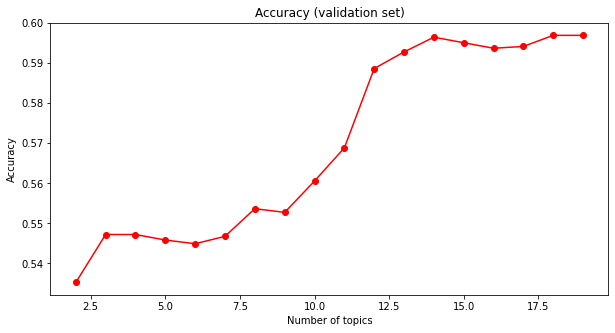

In [78]:
import matplotlib.pyplot as plt

def plot_accuracies(errors, x):
  
  fig, axes = plt.subplots(1,1, figsize=(10,5), sharex=False, sharey=False)
  ax1=axes
  

  
  ax1.plot(x,errors, color='red', marker="o")
  ax1.set_title('Accuracy (validation set)')
  ax1.set_xlabel('Number of topics')
  ax1.set_ylabel('Accuracy')

plot_accuracies(accuracies, list(c))

#### 3 genres
So the number of topics does not really make a difference, Around 8 or 10 topics good enough

#### 2 genres
4 topics is clearly the max that we need for this purpose

#### 3 genres 2 (Metal/Rock/HipHop)
9 topic has the highest accuracy

#### 4 genres
12 topics

## Creating BERT tokens

In [79]:
import transformers
# what we're used to: BERT
from transformers import BertTokenizer, BertModel 

MODEL_NAME = 'bert-base-uncased'
# Load pre-trained model
model = BertModel.from_pretrained(MODEL_NAME)
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)


In [80]:
# Test script
# %%time
# # one dimension of difference: speed
# samp_lyrics = x_train['Lyric'].iloc[:100]
# tokens = tokenizer.batch_encode_plus(x_train['Lyric'].iloc[:5],
#   pad_to_max_length=True, return_tensors="pt", 
#   max_length=512) # BERT expects sequences of 512 tokens
# outputs = model(**tokens)

In [81]:

# # start: 
# save_pickle('bert_lyrics_sm.pkl', outputs)
# save_pickle('all_data.pkl', (x_test, x_val, x_test, y_train, y_val, y_test))

# import gzip
# pickle.dump(outputs, gzip.open(f'{path}lyrics_bert_vectors.pkl.gz', 'wb'))

In [82]:
# outputs[0].shape # 5x512x768

In [83]:
# set the whole model to GPU
model.to(device)

# here we're doing small batches to the model on GPU, we'll load the product of this process later
# The model itself takes up a LOT of memory, so we're passing very small batches
# note here: You may run out of RAM if you try and run this along with all the above.

def generate_BERT_tokens(data, filename):
  
  st = 0
  batch_size = 5
  batches = list(range(batch_size, len(data), batch_size))+[len(data)]
  # print(batches)
  doc_rep_collector = []
  for b in batches:
      tokens = tokenizer.batch_encode_plus(
          data["Lyric"][st:b],
          pad_to_max_length=True, 
          return_tensors="pt",
          max_length=512,
          truncation=True)
      st = b
      tokens.to(device)
      outputs = model(**tokens)
      # taking the representation of the 'CLS' token (doc-level embedding)
      o = outputs[0][:,0].cpu().detach().numpy()
      doc_rep_collector.append(o)

  # stack into array
  doc_rep_collector = np.concatenate(doc_rep_collector)
  
  # to minimize size, can store as 16-bit float
  doc_rep_collector = doc_rep_collector.astype('float16')

  # additionally, will store as gzip (pandas can handle this)
  pickle.dump(doc_rep_collector, gzip.open(f'{path}{filename}', 'wb'))

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [84]:
%%time
if COLAB:
  generate_BERT_tokens(x_train, 'lyrics_bert_vectors_train.pkl.gz')
  

CPU times: user 1min 50s, sys: 1min 5s, total: 2min 55s
Wall time: 2min 55s


Laptop:
```
Wall time ~ 2min 40s for 100 records
```

Colab:
```
CPU times: user 1min 55s, sys: 1min 14s, total: 3min 10s
Wall time: 3min 10s
```

In [86]:
%%time
if COLAB:
  generate_BERT_tokens(x_val, 'lyrics_bert_vectors_val.pkl.gz')




CPU times: user 48.9 s, sys: 30.1 s, total: 1min 18s
Wall time: 1min 18s


Colab:
```
CPU times: user 52.5 s, sys: 34.1 s, total: 1min 26s
Wall time: 1min 26s,
```

In [87]:
%%time
if COLAB:
  generate_BERT_tokens(x_test, 'lyrics_bert_vectors_test.pkl.gz')

CPU times: user 1min 10s, sys: 44.3 s, total: 1min 54s
Wall time: 1min 54s


Colab
```
CPU times: user 1min 11s, sys: 46.8 s, total: 1min 58s
Wall time: 1min 58s
```

In [89]:
# load the BERT tokens
lyrics_bert_vectors_train = pd.read_pickle(f'{path}lyrics_bert_vectors_train.pkl.gz')
lyrics_bert_vectors_val = pd.read_pickle(f'{path}lyrics_bert_vectors_val.pkl.gz')
lyrics_bert_vectors_test = pd.read_pickle(f'{path}lyrics_bert_vectors_test.pkl.gz')

In [90]:
# BERT prediction
train_SVC(lyrics_bert_vectors_train, y_train["Genre"], lyrics_bert_vectors_val, y_val["Genre"])

Accuracy: 0.7


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.696453247351451